In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.image as mpimg
import seaborn as sns
import sys
!{sys.executable} -m pip install wget
!{sys.executable} -m pip install shutil
!{sys.executable} -m pip install cutmix-keras

import cv2
from tqdm import tqdm

import os
from shutil import unpack_archive
pd.set_option("display.max_columns", 101)

from cutmix_keras import CutMixImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, Flatten,Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=0a4c34ea1bea3e6463ffe177bb854abad20c98cd2b4c9ffda2e88042d2d33090
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement shutil (from versions: none)
ERROR: No matching distribution found for shutil
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Download dan extract dataset

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1b4DZIS7VfBI_V8-DbpsaCP0ij8u1K3hJ' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1b4DZIS7VfBI_V8-DbpsaCP0ij8u1K3hJ" -O dataset.zip && rm -rf /tmp/cookies.txt

unpack_archive('dataset.zip', '')

os.remove('dataset.zip')

--2022-07-23 13:44:14--  https://docs.google.com/uc?export=download&confirm=t&id=1b4DZIS7VfBI_V8-DbpsaCP0ij8u1K3hJ
Resolving docs.google.com (docs.google.com)... 142.251.10.100, 142.251.10.139, 142.251.10.138, ...
Connecting to docs.google.com (docs.google.com)|142.251.10.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/477l9s4oqu8649oo3bt3ovgpvl52t943/1658583825000/11309364930090306574/*/1b4DZIS7VfBI_V8-DbpsaCP0ij8u1K3hJ?e=download&uuid=2fb15fa5-5cb4-4040-a9f9-16979448dab8 [following]
--2022-07-23 13:44:15--  https://doc-00-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/477l9s4oqu8649oo3bt3ovgpvl52t943/1658583825000/11309364930090306574/*/1b4DZIS7VfBI_V8-DbpsaCP0ij8u1K3hJ?e=download&uuid=2fb15fa5-5cb4-4040-a9f9-16979448dab8
Resolving doc-00-90-docs.googleusercontent.com (doc-00-90-docs.googleusercontent.com)... 74.125.24.132, 2

In [3]:
# get label
label = os.listdir('train')
print(label)

['angry', 'fear', 'neutral', 'happy', 'surprise', 'sad', 'disgust']


In [4]:
data_label = []
for nama_label in label:
    jumlah = len(os.listdir(os.path.join('train', nama_label)))
    #print(jumlah)
    detail_label = [nama_label, jumlah]
    data_label.append(detail_label)

print(data_label)

[['angry', 3993], ['fear', 4103], ['neutral', 4982], ['happy', 7164], ['surprise', 3205], ['sad', 4938], ['disgust', 436]]


In [5]:
df_label = pd.DataFrame(data_label)
df_label.columns = ['Ekspresi', 'Jumlah']
df_label

,Ekspresi,Jumlah
0,angry,3993
1,fear,4103
2,neutral,4982
3,happy,7164
4,surprise,3205
5,sad,4938
6,disgust,436


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


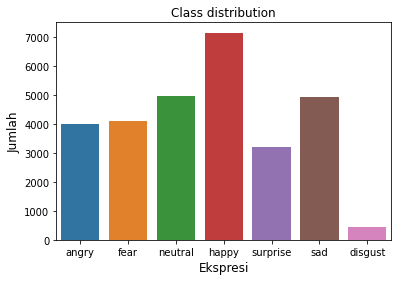

In [6]:
plt.figure(figsize=(6,4))
sns.barplot(df_label.Ekspresi, df_label.Jumlah)
plt.title('Class distribution')
plt.ylabel('Jumlah', fontsize=12)
plt.xlabel('Ekspresi', fontsize=12)
plt.show()

In [7]:
# Jumlah data training

jumlah_training = 0
jumlah_validation = 0 
for nama_label in label:
    jumlah_train = len(os.listdir(os.path.join('train', nama_label)))
    jumlah_val = len(os.listdir(os.path.join('validation', nama_label)))
    jumlah_training += jumlah_train
    jumlah_validation += jumlah_val

print('jumlah data training sebanyak', jumlah_training)
print('jumlah data validaiton sebanyak', jumlah_validation)

jumlah data training sebanyak 28821
jumlah data validaiton sebanyak 7066


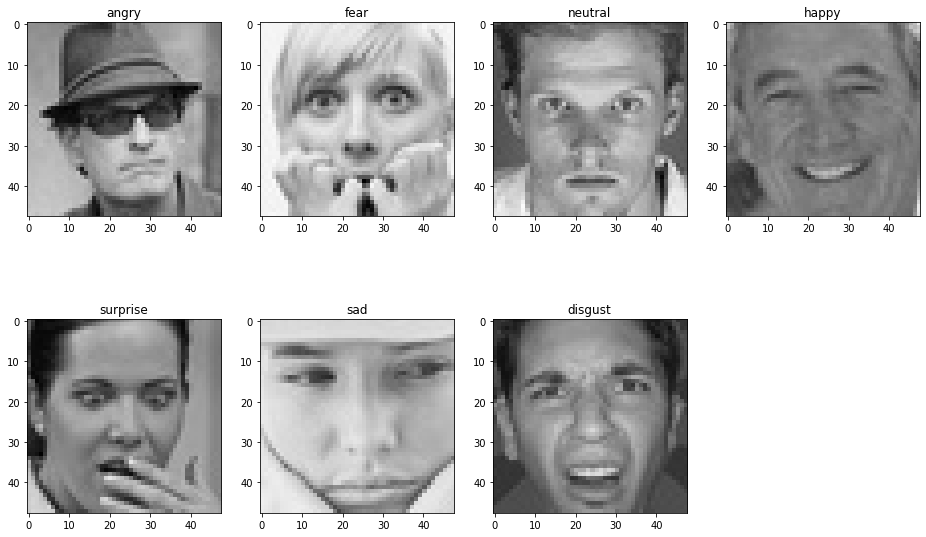

In [8]:
def gambarWajah(gambar, jenis_ekpresi, path):
    #pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    #img = np.array(pixels.split())
    gambar_dir = os.path.join(path, jenis_ekpresi)
    gambar_path = os.path.join(gambar_dir, gambar)
    img = mpimg.imread(gambar_path)
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), jenis_ekpresi], dtype=object)

plt.figure(0, figsize=(16,10))
i = 1;
for nama_ekspresi in label:
    #print(nama_ekspresi)
    gambar_dir = os.path.join('train', nama_ekspresi)
    list_gambar_ekspresi = os.listdir(gambar_dir)
    nama_gambar = list_gambar_ekspresi[0]
    img = gambarWajah(nama_gambar, nama_ekspresi, 'train')
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])
    i+=1

plt.show()  

In [9]:
# Membuat Dataframe

data_foto_1 = []
nama_class_1 = []
for label in os.listdir(os.path.join('train')):
  for img in os.listdir(os.path.join('train', label)):
    data_foto_1.append(img)
    nama_class_1.append(label)

training_df = pd.DataFrame({'image' : data_foto_1, 'label' : nama_class_1})

data_foto_2 = []
nama_class_2 = []
for label in os.listdir(os.path.join('validation')):
  for img in os.listdir(os.path.join('validation', label)):
    data_foto_2.append(img)
    nama_class_2.append(label)

validation_df = pd.DataFrame({'image' : data_foto_2, 'label' : nama_class_2})

training_df.info()
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28821 entries, 0 to 28820
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   28821 non-null  object
 1   label   28821 non-null  object
dtypes: object(2)
memory usage: 450.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7066 entries, 0 to 7065
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   7066 non-null   object
 1   label   7066 non-null   object
dtypes: object(2)
memory usage: 110.5+ KB


In [22]:
#initilize parameters
jumlah_class = 7
#width, height = 48, 48
jumlah_epochs = 200
ukuran_batch = 64
jumlah_features = 64

In [11]:
# Image Data Generator
train_datagen = ImageDataGenerator(
      # featurewise_center = True,
      # featurewise_std_normalization = True,
      rotation_range = 10,
      width_shift_range = 0.1,
      height_shift_range = 0.1,
      zoom_range = 0.1,
      horizontal_flip = True,
      fill_mode = 'nearest'
)
validation_datagen = ImageDataGenerator(horizontal_flip = True)

In [12]:
# Preprocess Data Biasa

train_generator = train_datagen.flow_from_directory(
    "train/",
    target_size=(48,48),
    batch_size = ukuran_batch,
    color_mode = 'grayscale',
    class_mode = "categorical"
)

validation_generator = validation_datagen.flow_from_directory(
    "validation/",
    target_size=(48,48),
    batch_size = ukuran_batch,
    color_mode = 'grayscale',
    class_mode = "categorical"
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


Model terbaik saat ini dengan akurasi train 0.59 dan akurasi validation 0.60 adalah
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(64, (3,3), activation="relu", input_shape=(48,48,1)),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Conv2D(16, (3,3), activation="relu"),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation="relu"),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(7, activation="softmax")
])

In [23]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(64, (3,3), activation="relu", input_shape=(48,48,1)),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    # tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    # tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    # tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Conv2D(16, (3,3), activation="relu"),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    # tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation="relu"),
                                    tf.keras.layers.BatchNormalization(),
                                    # tf.keras.layers.Dropout(0.2),
                                    # tf.keras.layers.Dense(64, activation="relu"),
                                    # tf.keras.layers.BatchNormalization(),
                                    # tf.keras.layers.Dropout(0.2),
                                    # tf.keras.layers.Dense(16, activation="relu"),
                                    # tf.keras.layers.BatchNormalization(),
                                    # tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(7, activation="softmax")
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 46, 46, 64)        640       
                                                                 
 batch_normalization_16 (Bat  (None, 46, 46, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 21, 21, 32)        18464     
                                                                 
 batch_normalization_17 (Bat  (None, 21, 21, 32)       128       
 chNormalization)                                                
                                                      

In [24]:
# Compile model

model.compile(optimizer=Adam(lr=0.0001), loss="categorical_crossentropy", metrics = ["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [25]:
# Fit model

history = model.fit(
    train_generator, 
    validation_data = validation_generator,
    epochs=jumlah_epochs, 
    steps_per_epoch = jumlah_training/ukuran_batch,
    validation_steps = jumlah_validation/ukuran_batch,
    verbose = 1,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
)

Epoch 1/200
450/450 [==============================] - 20s 43ms/step - loss: 2.1440 - accuracy: 0.1960 - val_loss: 1.9888 - val_accuracy: 0.2297
Epoch 2/200
450/450 [==============================] - 19s 43ms/step - loss: 1.8977 - accuracy: 0.2480 - val_loss: 1.9184 - val_accuracy: 0.2784
Epoch 3/200
450/450 [==============================] - 19s 43ms/step - loss: 1.8027 - accuracy: 0.2827 - val_loss: 1.8347 - val_accuracy: 0.2935
Epoch 4/200
450/450 [==============================] - 19s 43ms/step - loss: 1.7366 - accuracy: 0.3078 - val_loss: 1.7283 - val_accuracy: 0.3296
Epoch 5/200
450/450 [==============================] - 20s 45ms/step - loss: 1.6881 - accuracy: 0.3297 - val_loss: 1.6772 - val_accuracy: 0.3521
Epoch 6/200
450/450 [==============================] - 19s 43ms/step - loss: 1.6453 - accuracy: 0.3490 - val_loss: 1.6382 - val_accuracy: 0.3721
Epoch 7/200
450/450 [==============================] - 20s 44ms/step - loss: 1.6028 - accuracy: 0.3703 - val_loss: 1.6533 - val_ac